### Define your license plate file

In [65]:
src="img/0_4932XX_1.jpg"
#src="img/tailand_input/4thai-002thai-038599_20240716085937.jpg"  # +9
#src="img/tailand_input/3thai-002thai-0023343_20240715193348.jpg" # +5
#src="img/30deg-108-108.jpg" # +0
#src="img/30deg-108-54.jpg" # +5
#src="img/tailand_input/thai-002thai-0076888_20240715210831.jpg"  # +9
#src="img/tailand_input/1thai-001thai-02531_20240715161556.jpg"
#src="img/tmp/org_img/aaaaaaaaaaaaaaaa 1.jpg"
#src='Super Resolution_screenshot_25.05.2025.png'
src="img/tmp/org_img/aaaaaaaaaaaaaaaa 4.jpg"




### FFT rectify main program

In [70]:
import os, sys
import numpy as np
import math
from matplotlib import pyplot as plt
import cv2
import time
import statistics

isPlot=True
isBias=False
coreCut=0.01
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def fftplot(imgPath):
    img = cv2.imread(imgPath)
    pix_color = np.array(img)
    img = rgb2gray(pix_color)
    #print(img.shape)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))

    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()


def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def imgWrapA(orgImg,a):
    column=orgImg.shape[1]
    row=orgImg.shape[0]
    #plt.plot( int(column/2),int(row/2),'rx')#fix
    #plt.plot( int(column/2),int(row/4),'bx')#fix
    #plt.plot( int(column/4),int(row/2-column/4*a),'go')#offset
    pts1 = np.float32([[column/2,row/2],[column/2,row/4],[column/4,row/2-column/4*a]])
    pts2 = np.float32([[column/2,row/2],[column/2,row/4],[column/4,row/2]])
    M = cv2.getAffineTransform(pts1,pts2)
    imgWarpAffine = cv2.warpAffine(orgImg,M,(column,row))
    return imgWarpAffine

def estCorrect(orgImg0, cutoffF=0.8, margin=0.1):
    #orgImg = cv2.fastNlMeansDenoisingColored(orgImg0,None,9,9,7,21)
    orgImg = orgImg0
    w=orgImg.shape[1]
    print("w=",w)
    h=orgImg.shape[0]
    print("h=",h)
    crop_img = orgImg[:, int(margin*w):int(w-margin*w)]
    pix_color = np.array(crop_img)
    full_pix_color = np.array(orgImg)
    img = rgb2gray(pix_color)
    img=abs(img[0:-1,:]-img[1:,:])
    
    print(img.shape)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
        
    #plt.subplot(143),plt.imshow(np.abs(fshift), cmap = 'gray')
    #plt.title('np.abs(fshift)'), plt.xticks([]), plt.yticks([])
    margin = 0.9 # Cut off the outer 10% of the image
    # Do the polar rotation along 100 angular steps with a radius of 256 pixels.
    size=min(img.shape)
    polar_img = cv2.warpPolar(magnitude_spectrum, (int(size/2), 200), (img.shape[1]/2,img.shape[0]/2), 
                                  size*margin*0.5, cv2.WARP_POLAR_LINEAR)
    #print(polar_img.shape)

    polar_img_lowF=polar_img[:,int(coreCut*polar_img.shape[1]):int(cutoffF*polar_img.shape[1])]
    
    polar_sum_200=np.sum(polar_img_lowF,axis=1)
    polar_sum=polar_sum_200[0:100]+polar_sum_200[100:200]
    #polar_sum[50]=min(polar_sum) #matthew  do not count center line
    #print(statistics.stdev(polar_sum[25:75]))
    gainStdev=statistics.stdev(polar_sum[25:75])/10000
    print("isBias=",isBias)
    if isBias:
        polar_sum[45:56]=(polar_sum[45:56]*GAIN*gainStdev+polar_sum[45:56]*(1-gainStdev))
    #maxIndex=np.argmax(polar_sum[25:75])+25
    maxIndex=np.argmax(polar_sum)
    print("maxIndex=",maxIndex)
    #print(polar_sum)
    #maxIndex=maxIndex+0

    offsetDegree=(maxIndex-50)/100*3.14
    print("offsetDegree=",offsetDegree/3.14*180)
    rec_offsetDegree=math.atan(math.tan(offsetDegree)*h/w)
    offsetDegree=rec_offsetDegree
    print("rec_offsetDegree=",rec_offsetDegree/3.14*180)
    aEst=np.sin(offsetDegree)
    #correctImg=imgWrapA(pix_color,aEst)
    full_pix_color0 = np.array(orgImg0)
    correctImg=imgWrapA(full_pix_color0,aEst)
    #full_pix_color
    #polar_sum[25:75]=min(polar_sum) #matthew  do not count center line
    #maxIndex2=np.argmax(polar_sum)
    #print("maxIndex2={}".format(maxIndex2))
    
    if isPlot:
        plt.subplots(1,5,figsize=(15,3))
        plt.subplot(151),plt.imshow(img, cmap = 'gray')
        plt.title('Input Image w/ vertical diff')
        plt.subplot(152),plt.imshow(magnitude_spectrum, cmap = 'gray')
        plt.title('Magnitude Spectrum')
        plt.subplot(153),plt.imshow(polar_img, cmap = 'gray')
        plt.title('polar_img')
        plt.subplot(154),plt.plot(polar_sum)
        #print(polar_sum-min(polar_sum))
        plt.title('polar_sum')
        plt.subplot(155),plt.imshow(correctImg)
        plt.title('correctImg')
        plt.show()
    return correctImg

def estCorrect2D(orgImg, cutoffF=0.8, margin=0.1):
    hCorrectedImg=estCorrect(orgImg, cutoffF, margin)
    hCorrectedImg90=np.rot90(hCorrectedImg, )
    vCorrectedImg=estCorrect(hCorrectedImg90, cutoffF, margin)
    vCorrectedImg270=np.rot90(vCorrectedImg,  k=3)
    if isPlot:
        plt.subplots(1,3,figsize=(12,4))
        plt.subplot(131),plt.imshow(orgImg)
        plt.title('Input Image'), plt.xticks([]), plt.yticks([])
        plt.subplot(132),plt.imshow(hCorrectedImg)
        plt.title('Vertical rectify result'), plt.xticks([]), plt.yticks([])
        plt.subplot(133),plt.imshow(vCorrectedImg270)
        plt.title('Horizontal rectify result'), plt.xticks([]), plt.yticks([])
        plt.show()
        
    
    return hCorrectedImg, vCorrectedImg270


def fftplotWarp(imgPath):
    orgImg_0 = cv2.imread(imgPath)
    orgImg = cv2.cvtColor(orgImg_0, cv2.COLOR_BGR2RGB)
    #orgImg = cv2.imread(imgPath)
    pix_color = np.array(orgImg)
    hCorrectedImg, CorrectedImg=estCorrect2D(pix_color, 0.8, 0.1)

    # Convert back to BGR for saving
    CorrectedImg_bgr = cv2.cvtColor(CorrectedImg, cv2.COLOR_RGB2BGR)

    # Build output path with _corrected.png suffix
    base, _ = os.path.splitext(imgPath)
    output_path = f"{base}_corrected.png"

    # Save the image
    cv2.imwrite(output_path, CorrectedImg_bgr)
    print(f"Saved corrected image to {output_path}")
    
        
#fftplotWarp(src)


In [67]:
w=108
h=54
r=math.atan(math.tan(3.14/4)*54/108)
d=r*180/3.14
d

26.560269994871284

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 54
offsetDegree= 7.2
rec_offsetDegree= 1.808924668388747


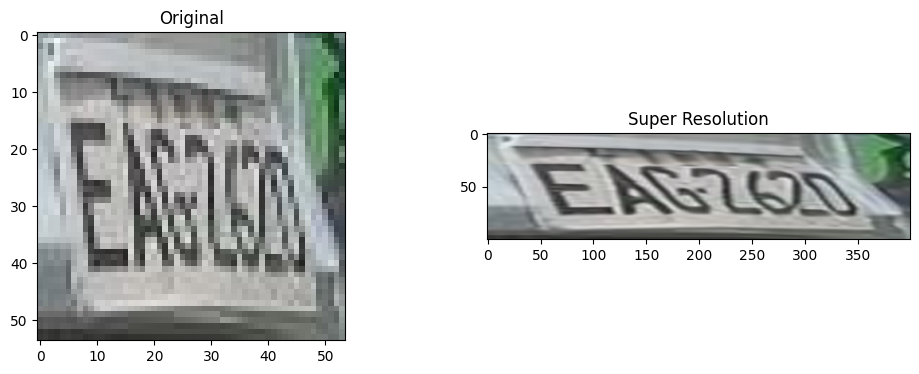

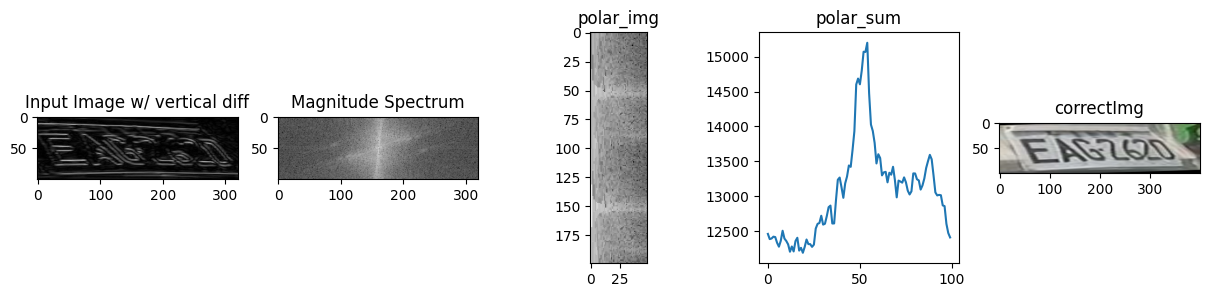

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 45
offsetDegree= -9.000000000000002
rec_offsetDegree= -32.35885517917708


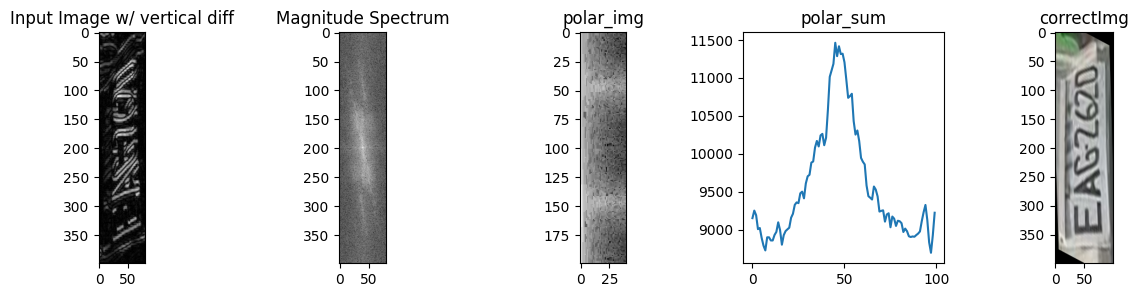

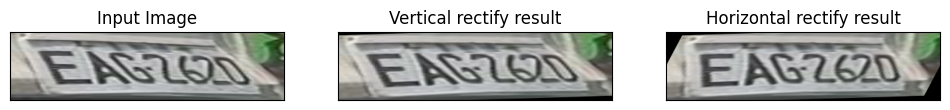

Saved corrected image to super_res_output_corrected.png


In [71]:
import cv2
from matplotlib import pyplot as plt

# Create the super resolution object
sr = cv2.dnn_superres.DnnSuperResImpl_create()

# Load the pre-trained EDSR model
model_path = "EDSR_x2.pb"  # https://github.com/Saafke/EDSR_Tensorflow/blob/master/models/EDSR_x2.pb
sr.readModel(model_path)

# Set the model name and scale
sr.setModel("edsr", 2)  # 'edsr' model with 4x upscaling

# Load the input image
image = cv2.imread(src)

# Apply super resolution
result_0 = sr.upsample(image)
result = cv2.resize(result_0, (400, 100), interpolation=cv2.INTER_CUBIC)

plt.subplots(1,2,figsize=(12,4))
plt.subplot(121),plt.imshow(image)
plt.title('Original')
plt.subplot(122),plt.imshow(result)
plt.title('Super Resolution')


# Optionally, save the result
cv2.imwrite("super_res_output.jpg", result)
fftplotWarp("super_res_output.jpg")


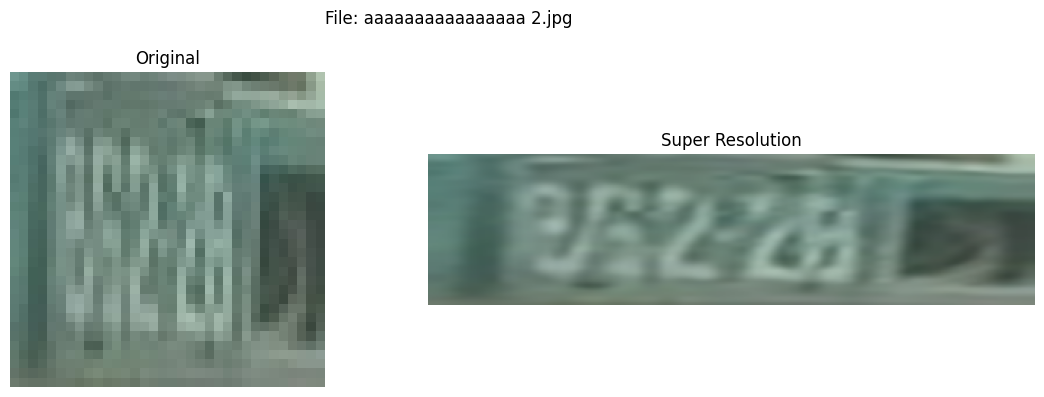

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 54
offsetDegree= 7.2
rec_offsetDegree= 1.808924668388747


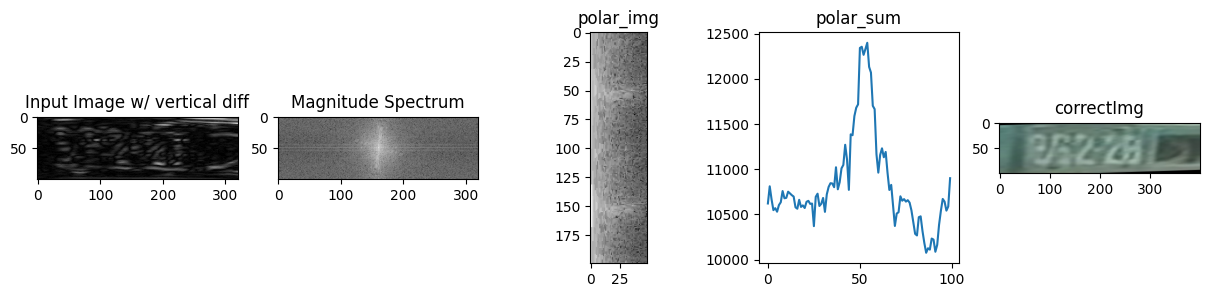

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 50
offsetDegree= 0.0
rec_offsetDegree= 0.0


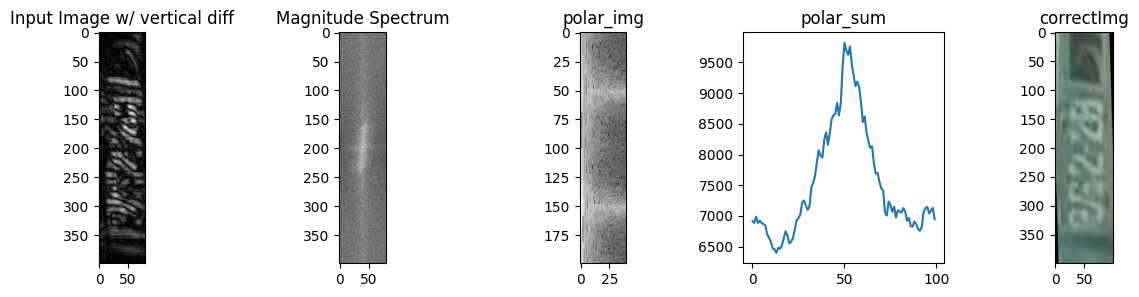

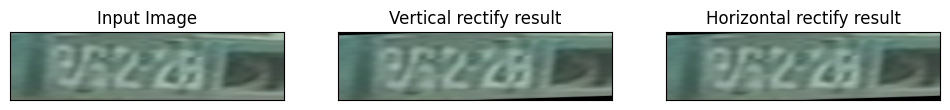

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 2_corrected.png


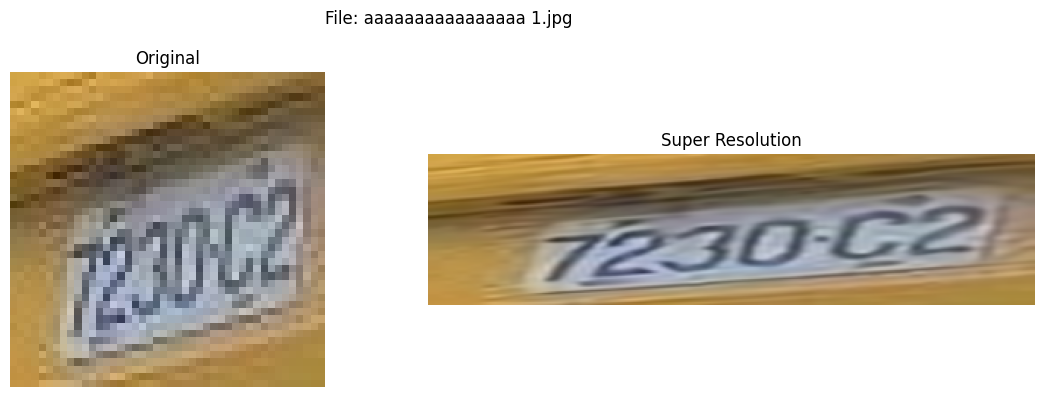

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 42
offsetDegree= -14.4
rec_offsetDegree= -3.67264987221799


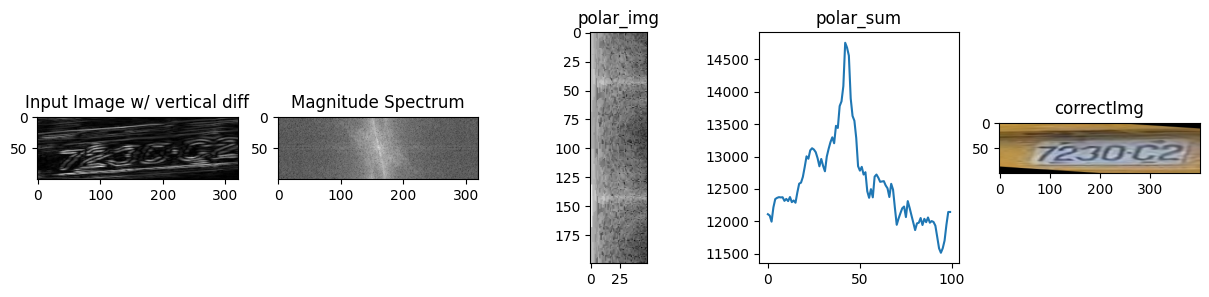

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 54
offsetDegree= 7.2
rec_offsetDegree= 26.81004350609588


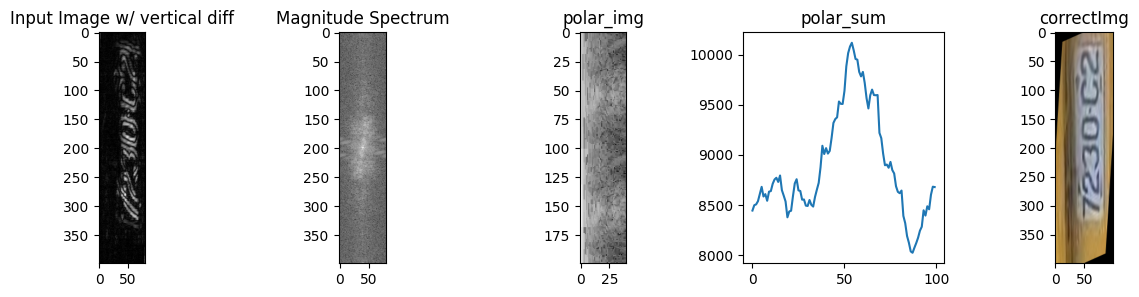

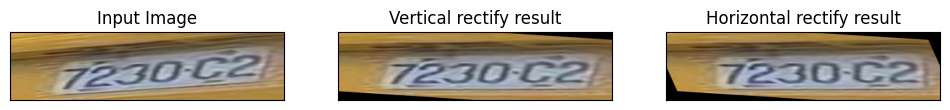

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 1_corrected.png


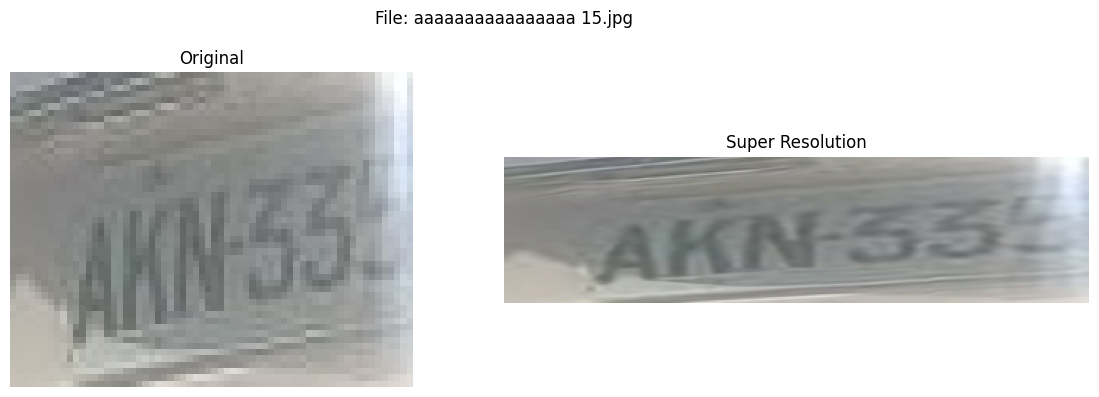

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 45
offsetDegree= -9.000000000000002
rec_offsetDegree= -2.2674875457953356


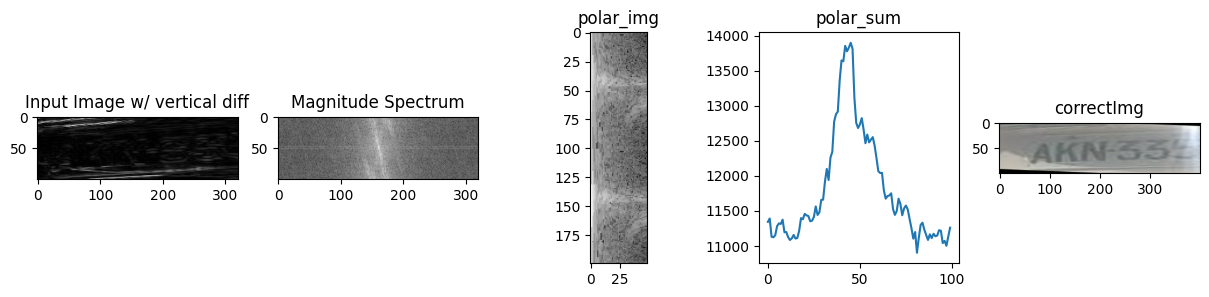

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 51
offsetDegree= 1.8
rec_offsetDegree= 7.164823969759842


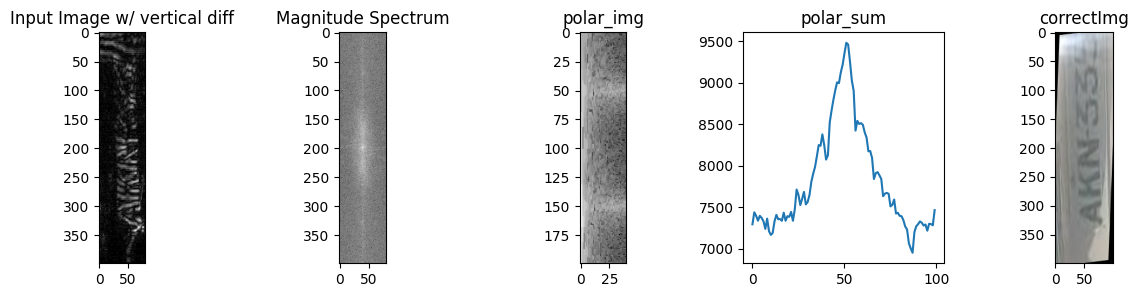

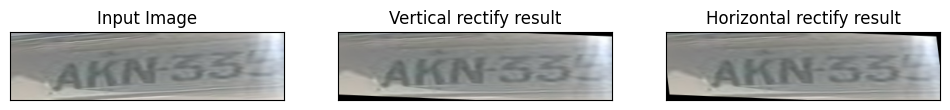

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 15_corrected.png


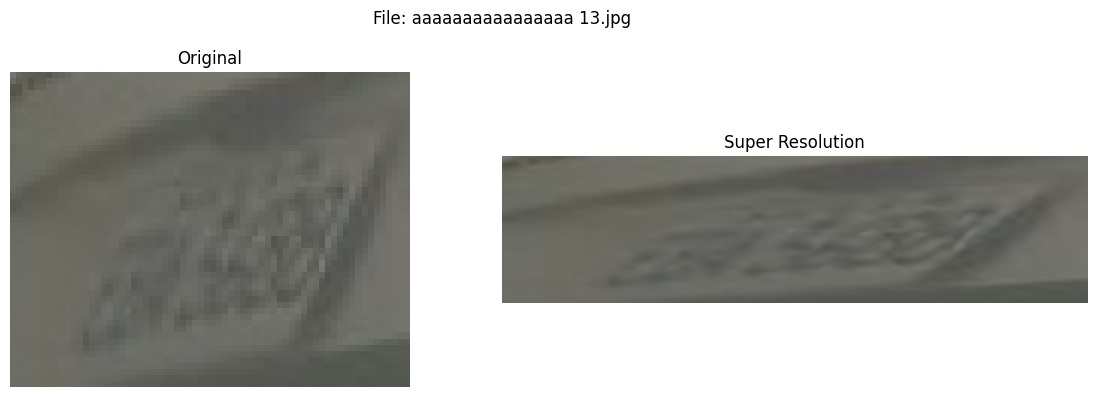

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 42
offsetDegree= -14.4
rec_offsetDegree= -3.67264987221799


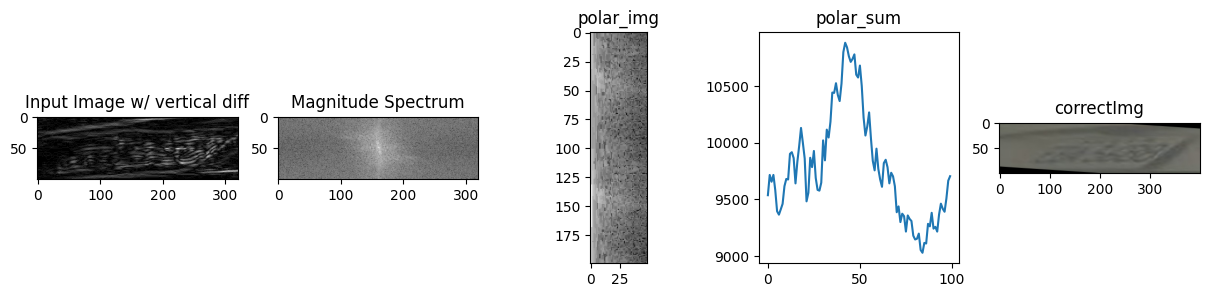

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 59
offsetDegree= 16.2
rec_offsetDegree= 49.29765110252427


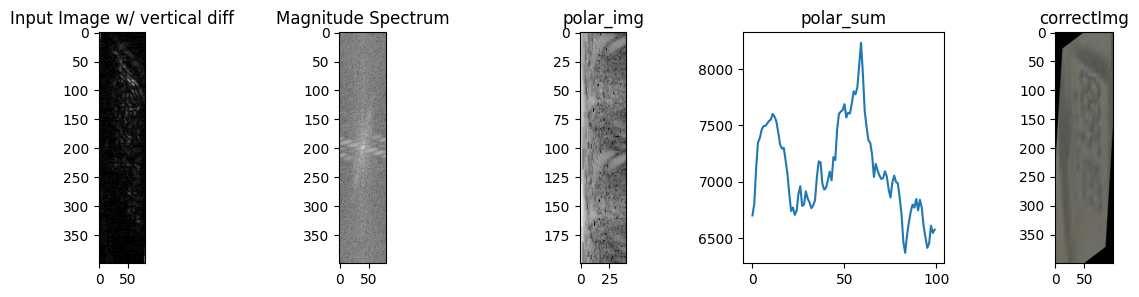

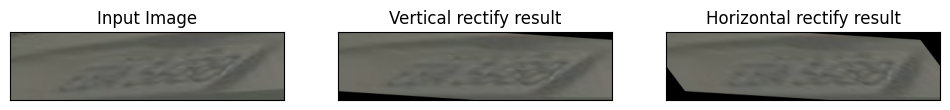

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 13_corrected.png


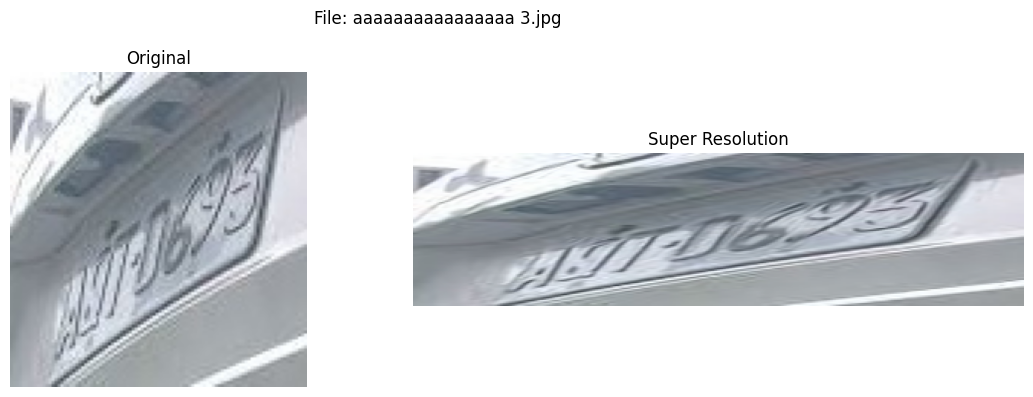

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 36
offsetDegree= -25.200000000000003
rec_offsetDegree= -6.709052158744026


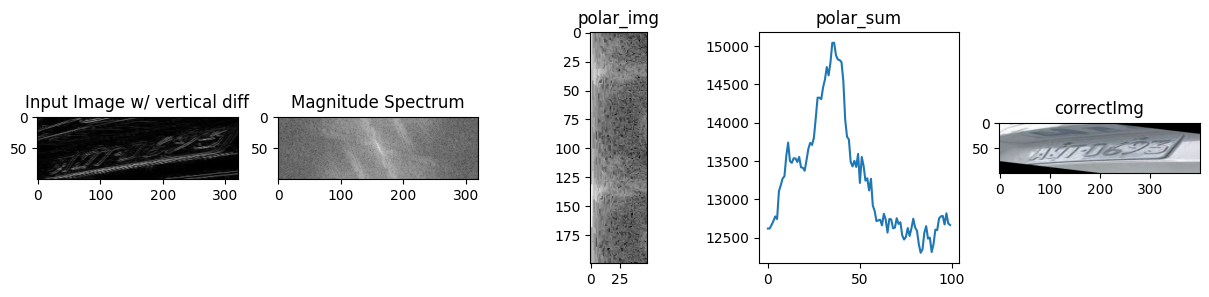

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 55
offsetDegree= 9.000000000000002
rec_offsetDegree= 32.35885517917708


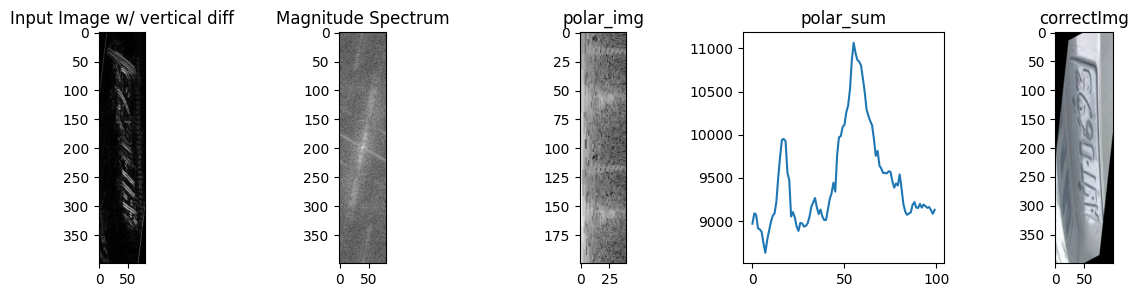

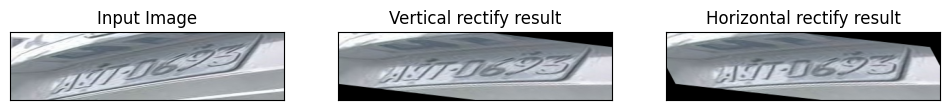

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 3_corrected.png


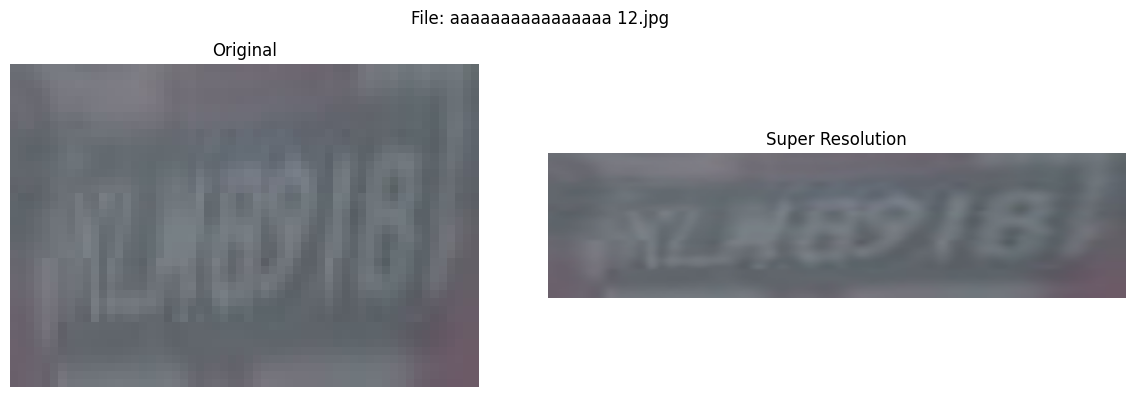

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 50
offsetDegree= 0.0
rec_offsetDegree= 0.0


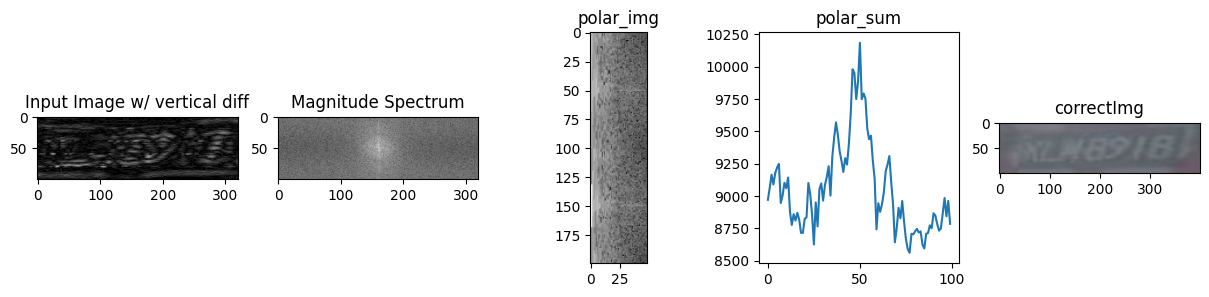

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 52
offsetDegree= 3.6
rec_offsetDegree= 14.12592144004449


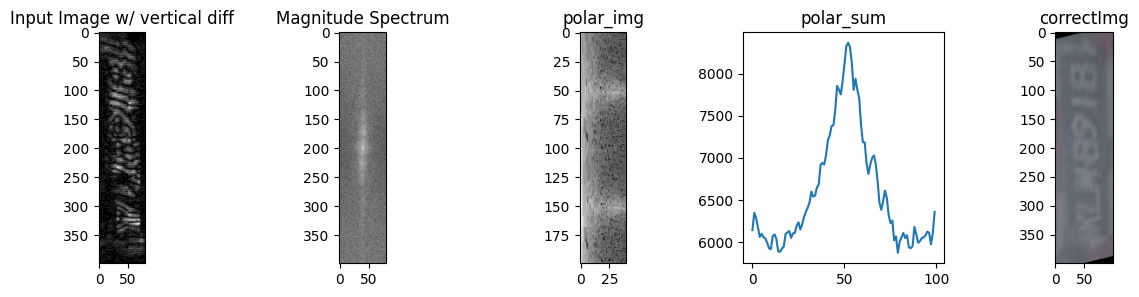

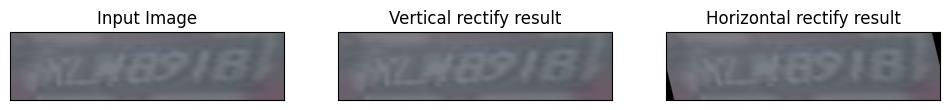

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 12_corrected.png


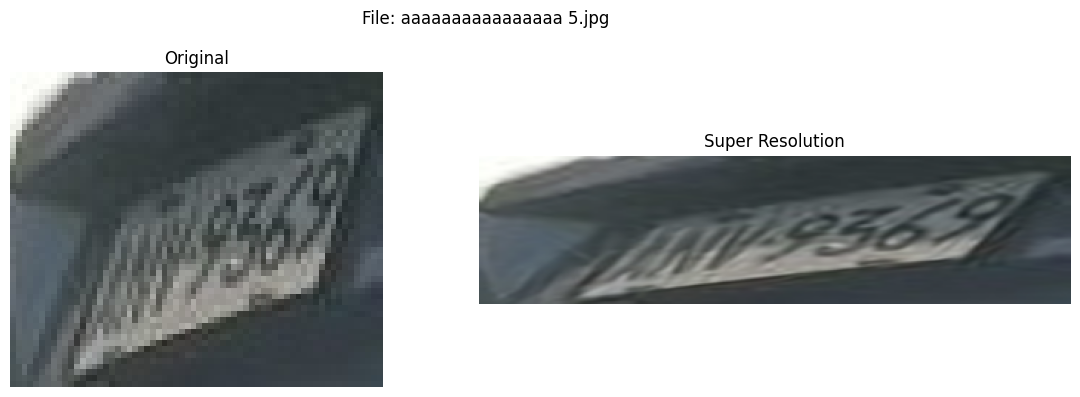

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 39
offsetDegree= -19.800000000000004
rec_offsetDegree= -5.142874788062298


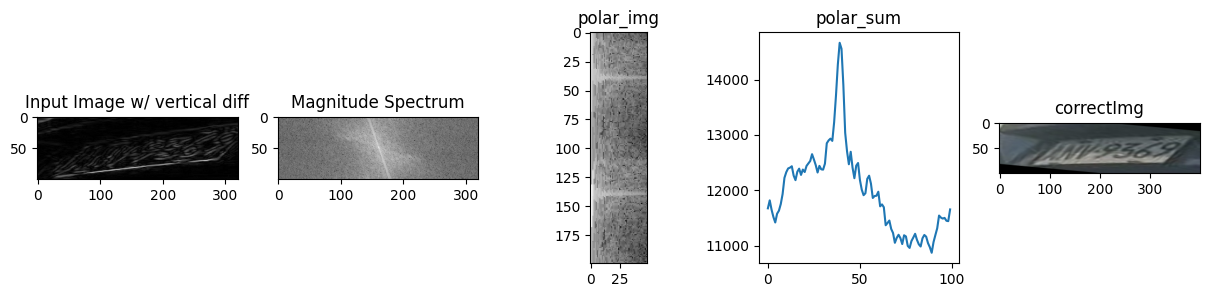

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 57
offsetDegree= 12.600000000000001
rec_offsetDegree= 41.806369412358166


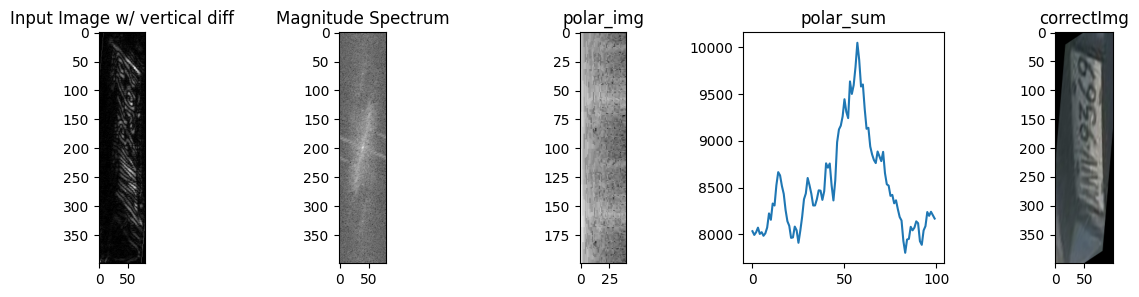

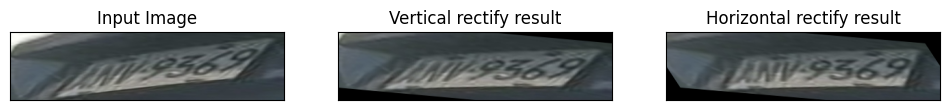

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 5_corrected.png


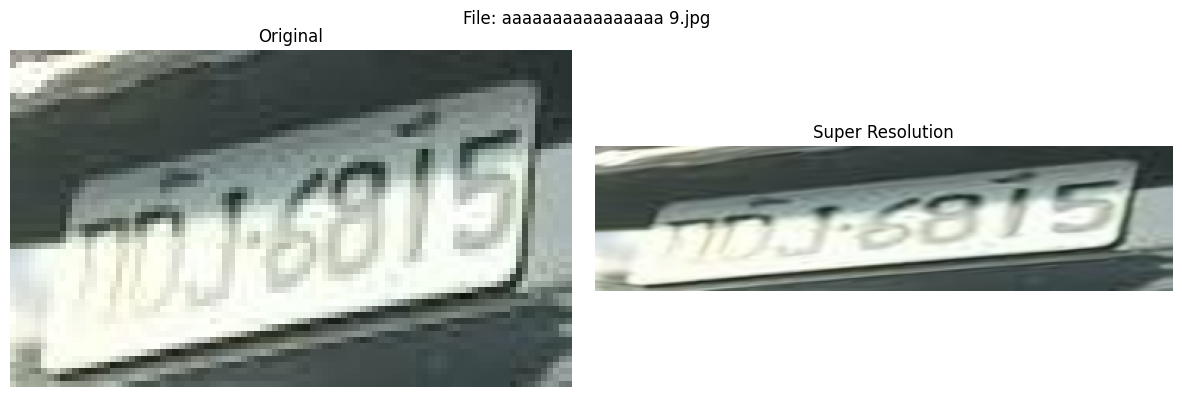

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 42
offsetDegree= -14.4
rec_offsetDegree= -3.67264987221799


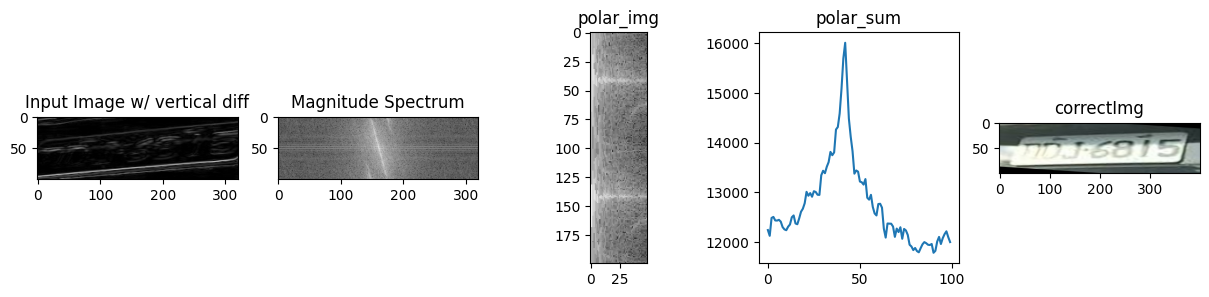

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 52
offsetDegree= 3.6
rec_offsetDegree= 14.12592144004449


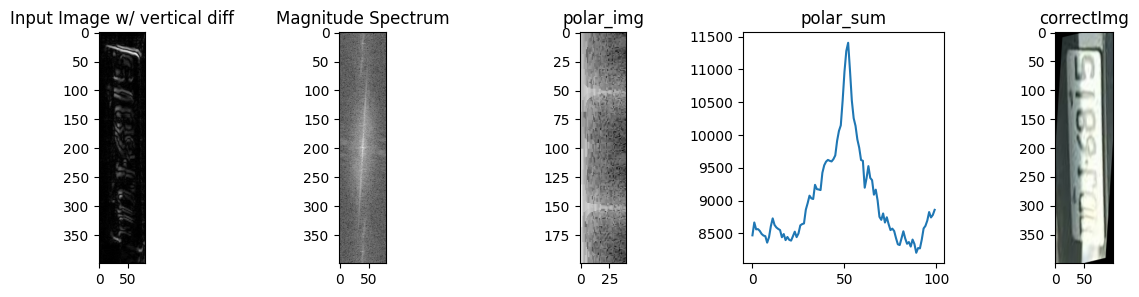

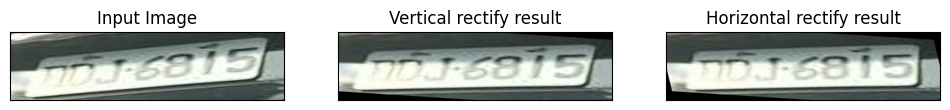

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 9_corrected.png


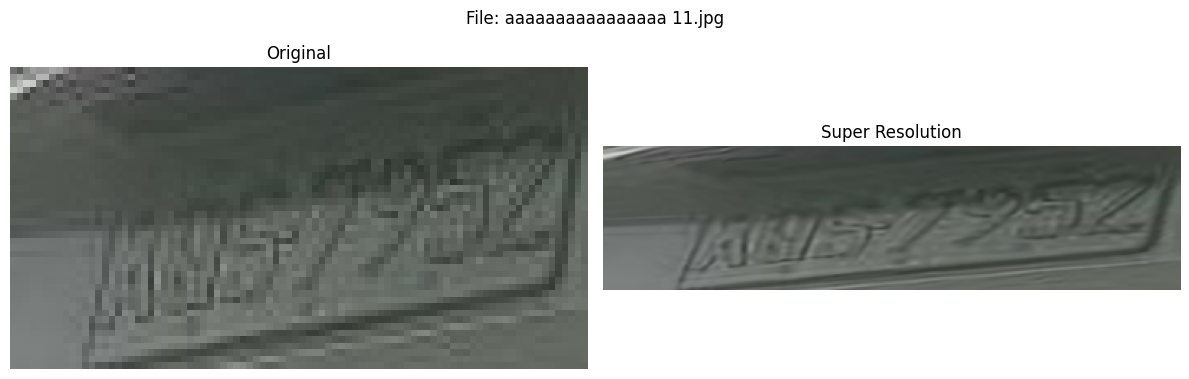

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 41
offsetDegree= -16.2
rec_offsetDegree= -4.154087199065155


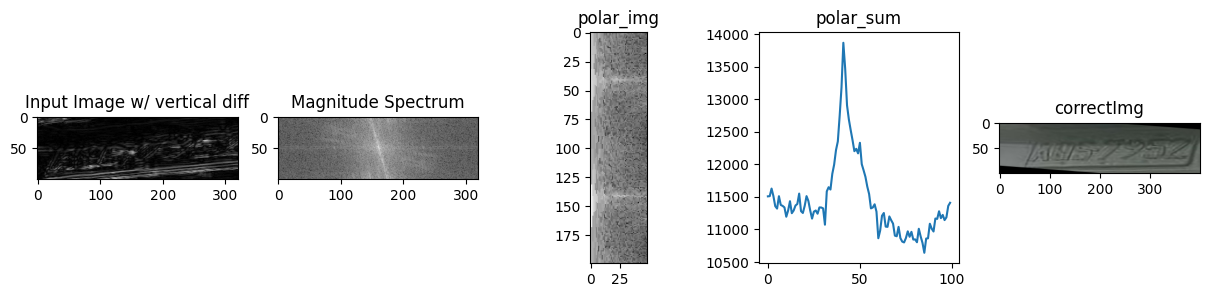

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 52
offsetDegree= 3.6
rec_offsetDegree= 14.12592144004449


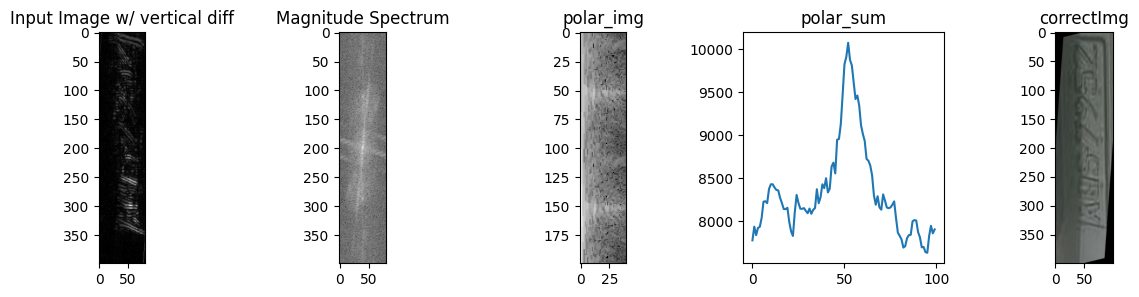

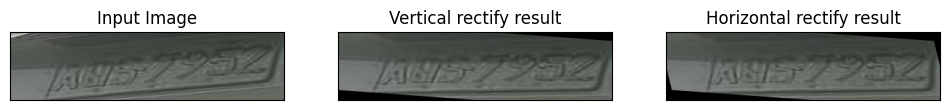

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 11_corrected.png


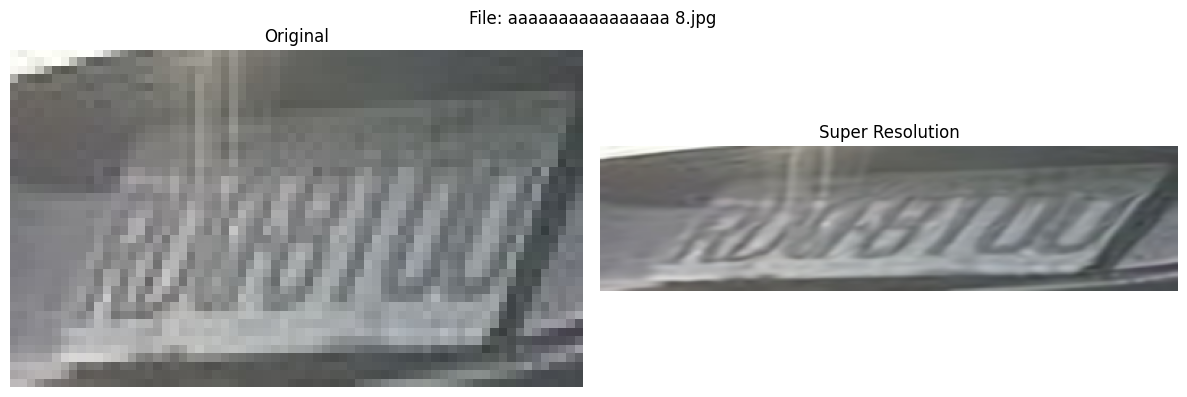

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 48
offsetDegree= -3.6
rec_offsetDegree= -0.9011107929749683


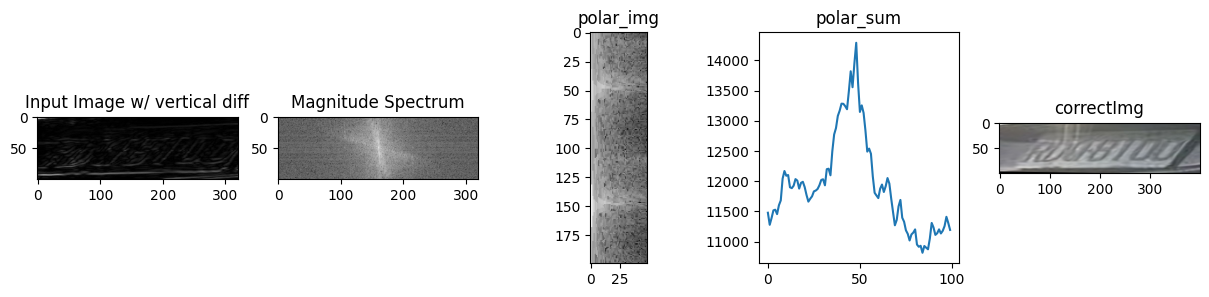

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 55
offsetDegree= 9.000000000000002
rec_offsetDegree= 32.35885517917708


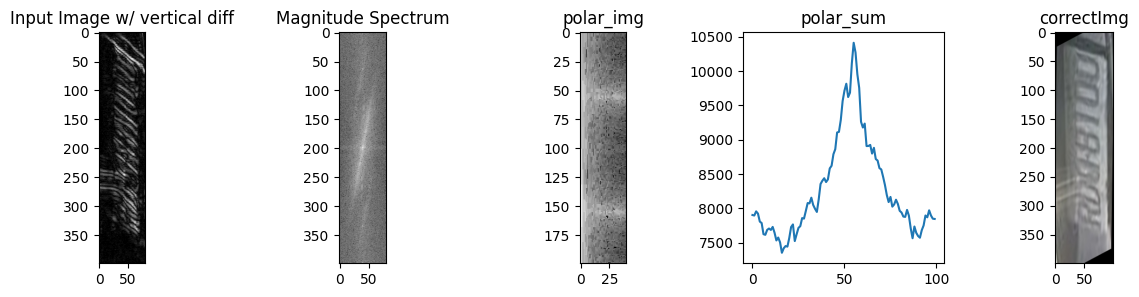

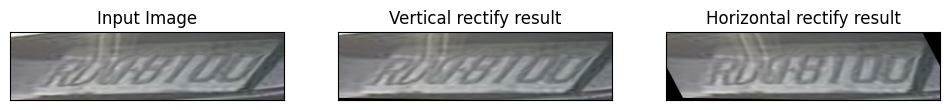

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 8_corrected.png


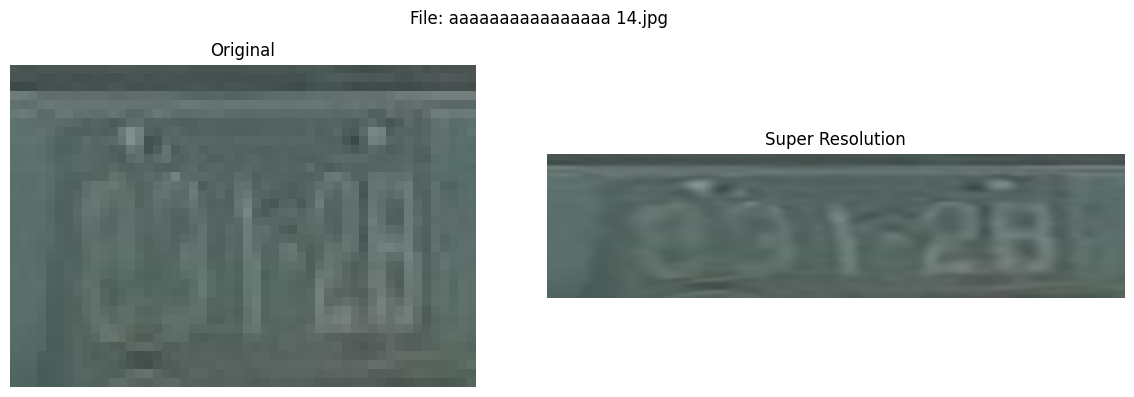

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 50
offsetDegree= 0.0
rec_offsetDegree= 0.0


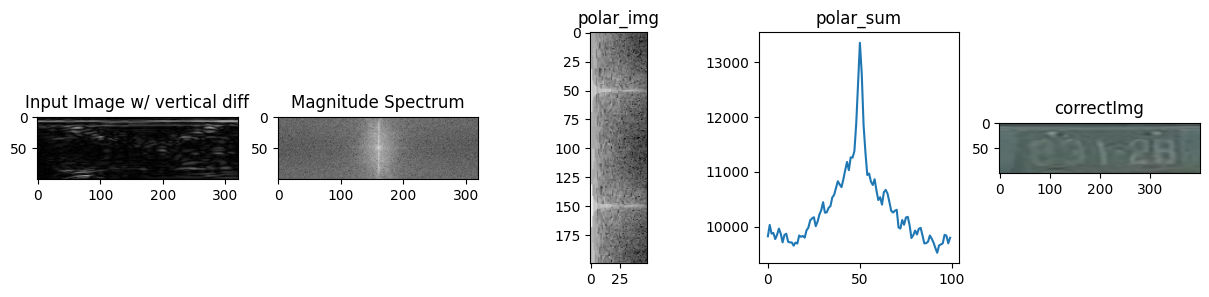

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 49
offsetDegree= -1.8
rec_offsetDegree= -7.164823969759842


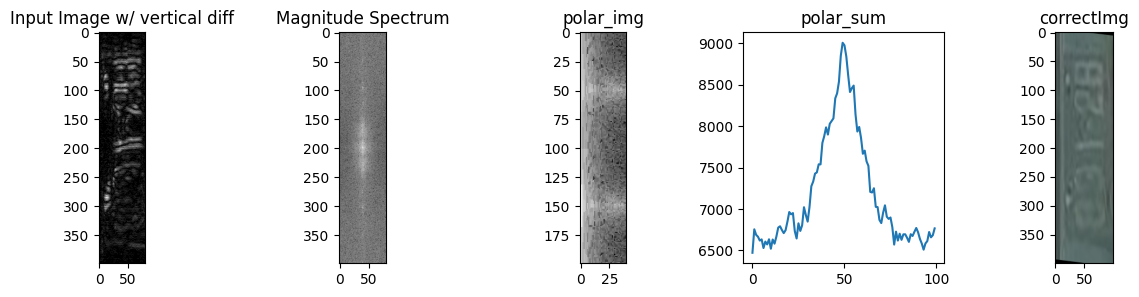

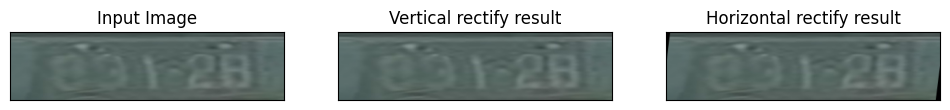

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 14_corrected.png


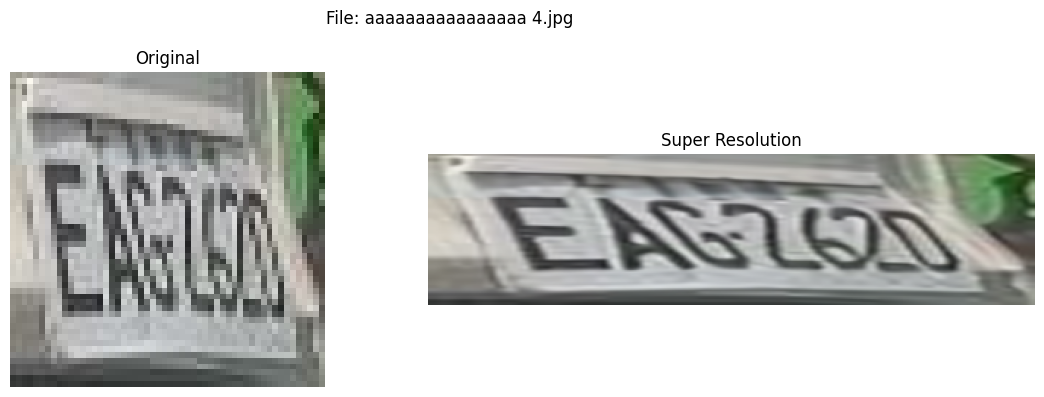

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 54
offsetDegree= 7.2
rec_offsetDegree= 1.808924668388747


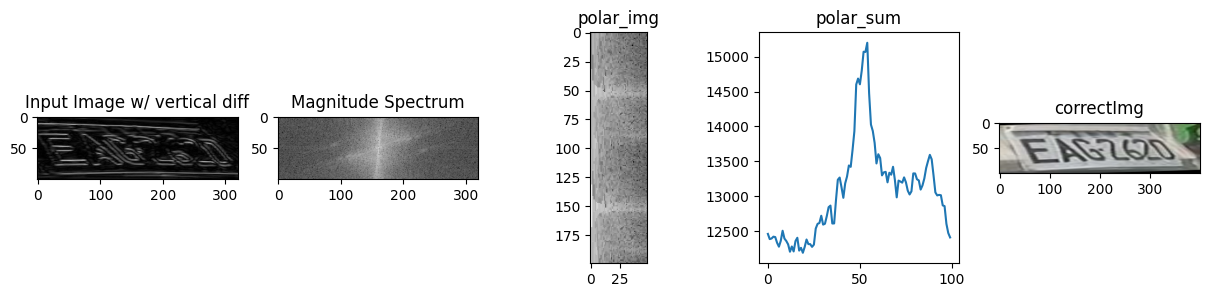

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 45
offsetDegree= -9.000000000000002
rec_offsetDegree= -32.35885517917708


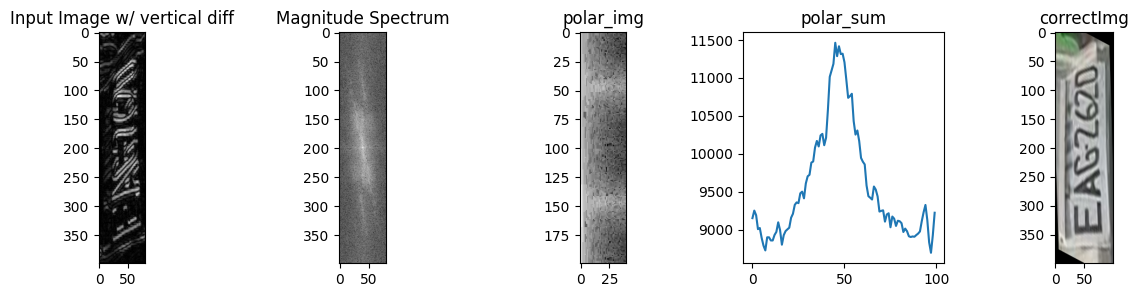

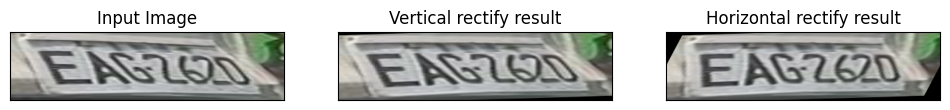

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 4_corrected.png


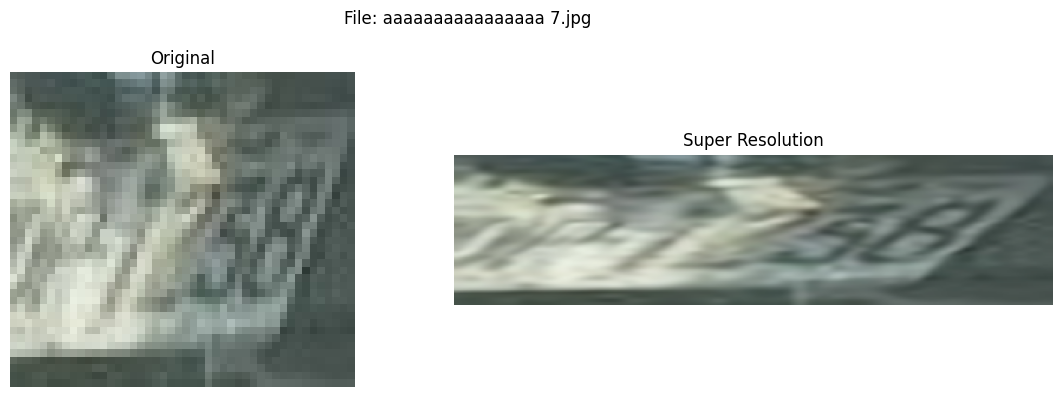

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 49
offsetDegree= -1.8
rec_offsetDegree= -0.4501387001974291


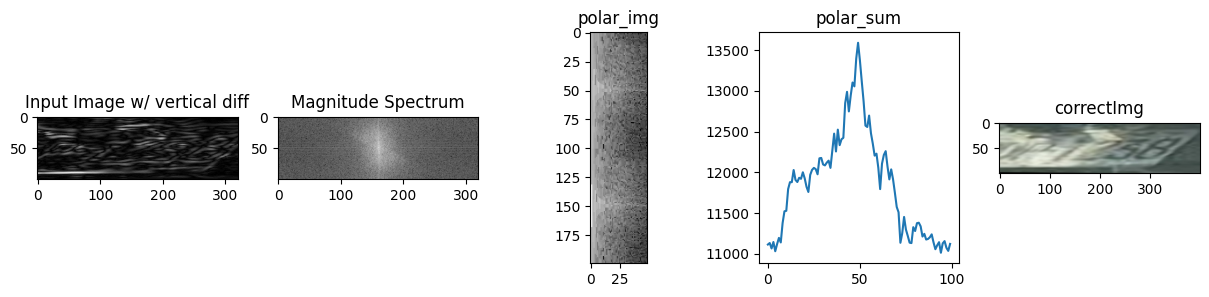

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 59
offsetDegree= 16.2
rec_offsetDegree= 49.29765110252427


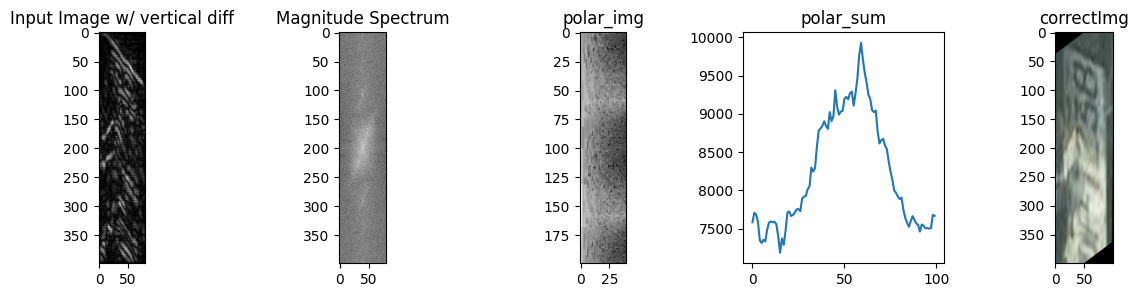

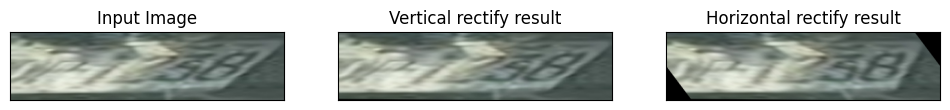

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 7_corrected.png


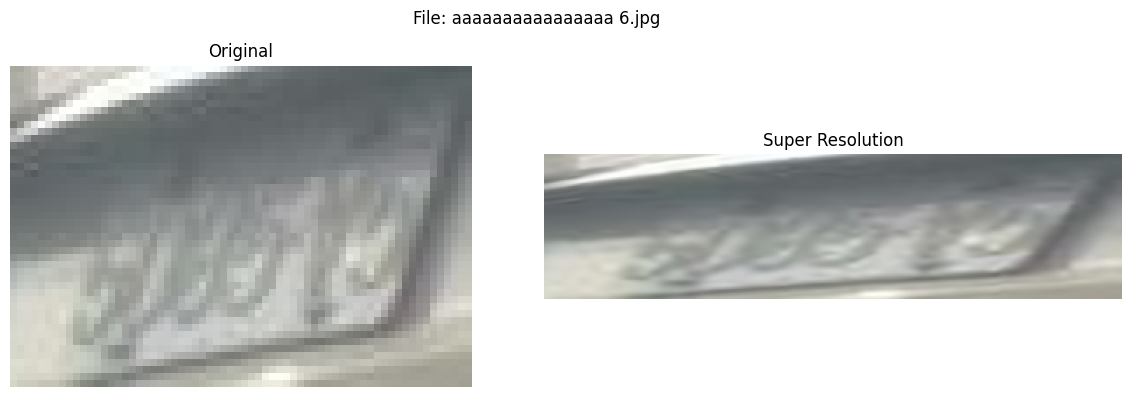

w= 400
h= 100
(99, 320)
isBias= False
maxIndex= 39
offsetDegree= -19.800000000000004
rec_offsetDegree= -5.142874788062298


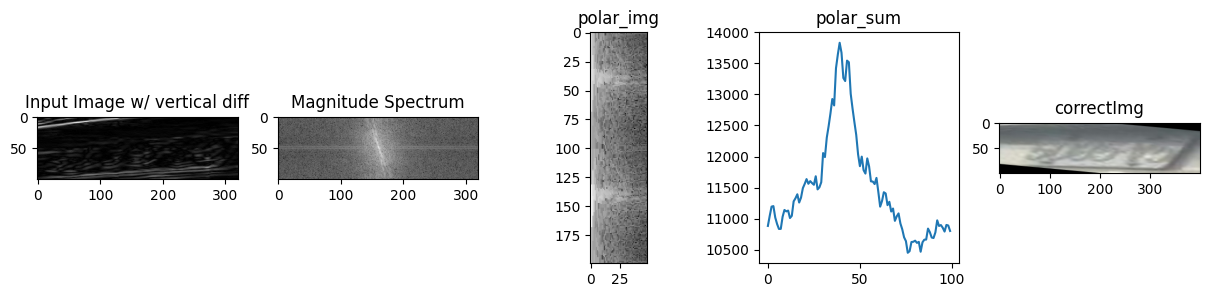

w= 100
h= 400
(399, 80)
isBias= False
maxIndex= 56
offsetDegree= 10.8
rec_offsetDegree= 37.349696341087146


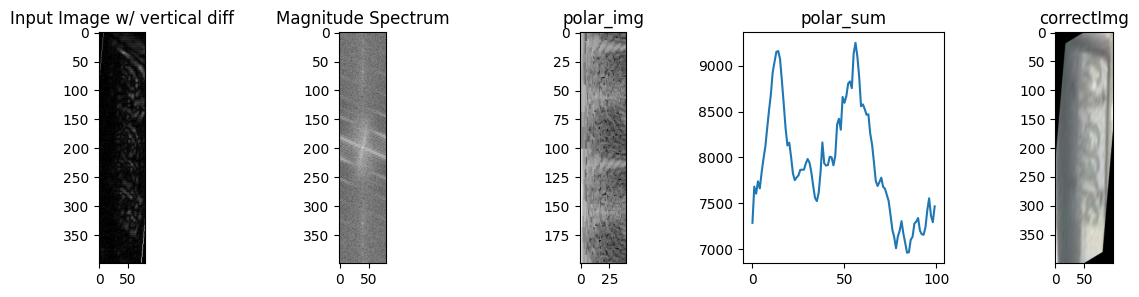

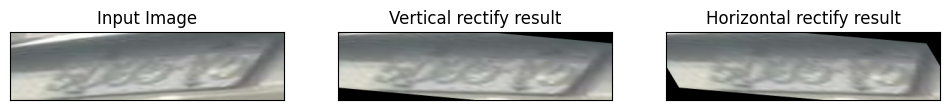

Saved corrected image to img/tmp/super_res_aaaaaaaaaaaaaaaa 6_corrected.png


In [72]:
import cv2
import glob
import os
from matplotlib import pyplot as plt

# Create the super resolution object
sr = cv2.dnn_superres.DnnSuperResImpl_create()

# Load the pre-trained EDSR model
model_path = "EDSR_x2.pb"
sr.readModel(model_path)

# Set the model name and scale
sr.setModel("edsr", 2)  # 'edsr' model with 2x upscaling

# Directory containing original images
image_dir = "img/tmp/org_img/"
image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

for img_path in image_paths:
    # Load image
    image = cv2.imread(img_path)

    if image is None:
        print(f"Failed to load {img_path}")
        continue

    # Apply super resolution
    result_0 = sr.upsample(image)
    result = cv2.resize(result_0, (400, 100), interpolation=cv2.INTER_CUBIC)

    # Convert BGR to RGB for matplotlib display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    # Plot original and result
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_rgb)
    plt.title('Super Resolution')
    plt.axis('off')

    plt.suptitle(f"File: {os.path.basename(img_path)}")
    plt.tight_layout()
    plt.show()

    # Optionally save result
    output_path = os.path.join("img/tmp", "super_res_" + os.path.basename(img_path))
    cv2.imwrite(output_path, result)

    # Optional custom function (only if you defined it)
    fftplotWarp(output_path)
